In [132]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pyslim
import tskit
from joblib import Parallel, delayed, parallel_config
from spatial import *

In [2]:
# fmt:off
IN = [
    Path("~/simulation-outputs/spatial-runs/spatial_0.4.trees").expanduser(),
    Path("~/simulation-outputs/spatial-runs-vary-two-SD/spatial_0.4.trees").expanduser(),
    Path("~/simulation-outputs/spatial-runs-vary-all-SD/spatial_0.4.trees").expanduser(),
    Path("~/simulation-outputs/spatial-runs/spatial_1.5.trees").expanduser(),
    Path("~/simulation-outputs/spatial-runs-vary-two-SD/spatial_1.5.trees").expanduser(),
    Path("~/simulation-outputs/spatial-runs-vary-all-SD/spatial_1.5.trees").expanduser(),
]

In [3]:
MU = 1e-8
SEED = 23

In [4]:
with parallel_config(verbose=10, n_jobs=15):
    TSS = Parallel()(delayed(load_slim_ts_and_mutate)(p, MU, SEED) for p in IN)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of   6 | elapsed:   11.0s remaining:   22.0s
[Parallel(n_jobs=15)]: Done   3 out of   6 | elapsed:   11.8s remaining:   11.8s
[Parallel(n_jobs=15)]: Done   4 out of   6 | elapsed:   12.6s remaining:    6.3s
[Parallel(n_jobs=15)]: Done   6 out of   6 | elapsed:   14.3s finished


In [5]:
def sample_in_rings(ts, W, sampling_times, sampled_seed=None, n_samples=None):
    return [
        get_individuals_at_time_space_rings(ts, t, W, 5, sampled_seed, n_samples)
        for t in sampling_times
    ]

In [6]:
SAMPLED = {
    t.label: sample_in_rings(t.ts, t.model_params["W"], t.sampling_times, SEED, 50)
    for t in TSS
}

In [7]:
PS = {t.label: compute_stats_parallel(t.ts, g) for t, g in zip(TSS, SAMPLED.values())}

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  20 | elapsed:  3.1min remaining: 17.7min


loading spatial-runs-vary-all-SD_spatial_0.4: /home/lkirk/simulation-outputs/spatial-runs-vary-all-SD/spatial_0.4.trees
Estimated generation time: 4.08517050705932 from first 527121 ticks
all trees have coalesced


/home/lkirk/repo/tskit-ld/ve/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=15)]: Done   6 out of  20 | elapsed:  4.2min remaining:  9.8min
[Parallel(n_jobs=15)]: Done   9 out of  20 | elapsed:  4.8min remaining:  5.8min


loading spatial-runs-vary-two-SD_spatial_1.5: /home/lkirk/simulation-outputs/spatial-runs-vary-two-SD/spatial_1.5.trees
Estimated generation time: 4.043660842782067 from first 444201 ticks
all trees have coalesced


[Parallel(n_jobs=15)]: Done  12 out of  20 | elapsed:  5.0min remaining:  3.3min


loading spatial-runs_spatial_1.5: /home/lkirk/simulation-outputs/spatial-runs/spatial_1.5.trees
Estimated generation time: 4.041133040970344 from first 482721 ticks
all trees have coalesced


[Parallel(n_jobs=15)]: Done  15 out of  20 | elapsed:  5.2min remaining:  1.7min


loading spatial-runs_spatial_0.4: /home/lkirk/simulation-outputs/spatial-runs/spatial_0.4.trees
Estimated generation time: 4.08517050705932 from first 527121 ticks
all trees have coalesced


[Parallel(n_jobs=15)]: Done  18 out of  20 | elapsed:  5.8min remaining:   38.4s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:  6.1min finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  20 | elapsed:  3.0min remaining: 17.0min
[Parallel(n_jobs=15)]: Done   6 out of  20 | elapsed:  4.0min remaining:  9.3min
[Parallel(n_jobs=15)]: Done   9 out of  20 | elapsed:  4.7min remaining:  5.7min
[Parallel(n_jobs=15)]: Done  12 out of  20 | elapsed:  4.8min remaining:  3.2min
[Parallel(n_jobs=15)]: Done  15 out of  20 | elapsed:  5.1min remaining:  1.7min
[Parallel(n_jobs=15)]: Done  18 out of  20 | elapsed:  5.4min remaining:   36.0s
[Parallel(n_jobs=15)]: Done  20 out of  20 | elapsed:  5.7min finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  20 | elapsed:  2.8min remaining: 16.1min
[Parallel(n_jobs=15)]: Done   6 out of  20 | elapsed:  4

In [10]:
# plot_divergence_upper_tri(ps.divergence, ps.geog_distance, ps.ind_groups[ps.pairs], ps.groups)

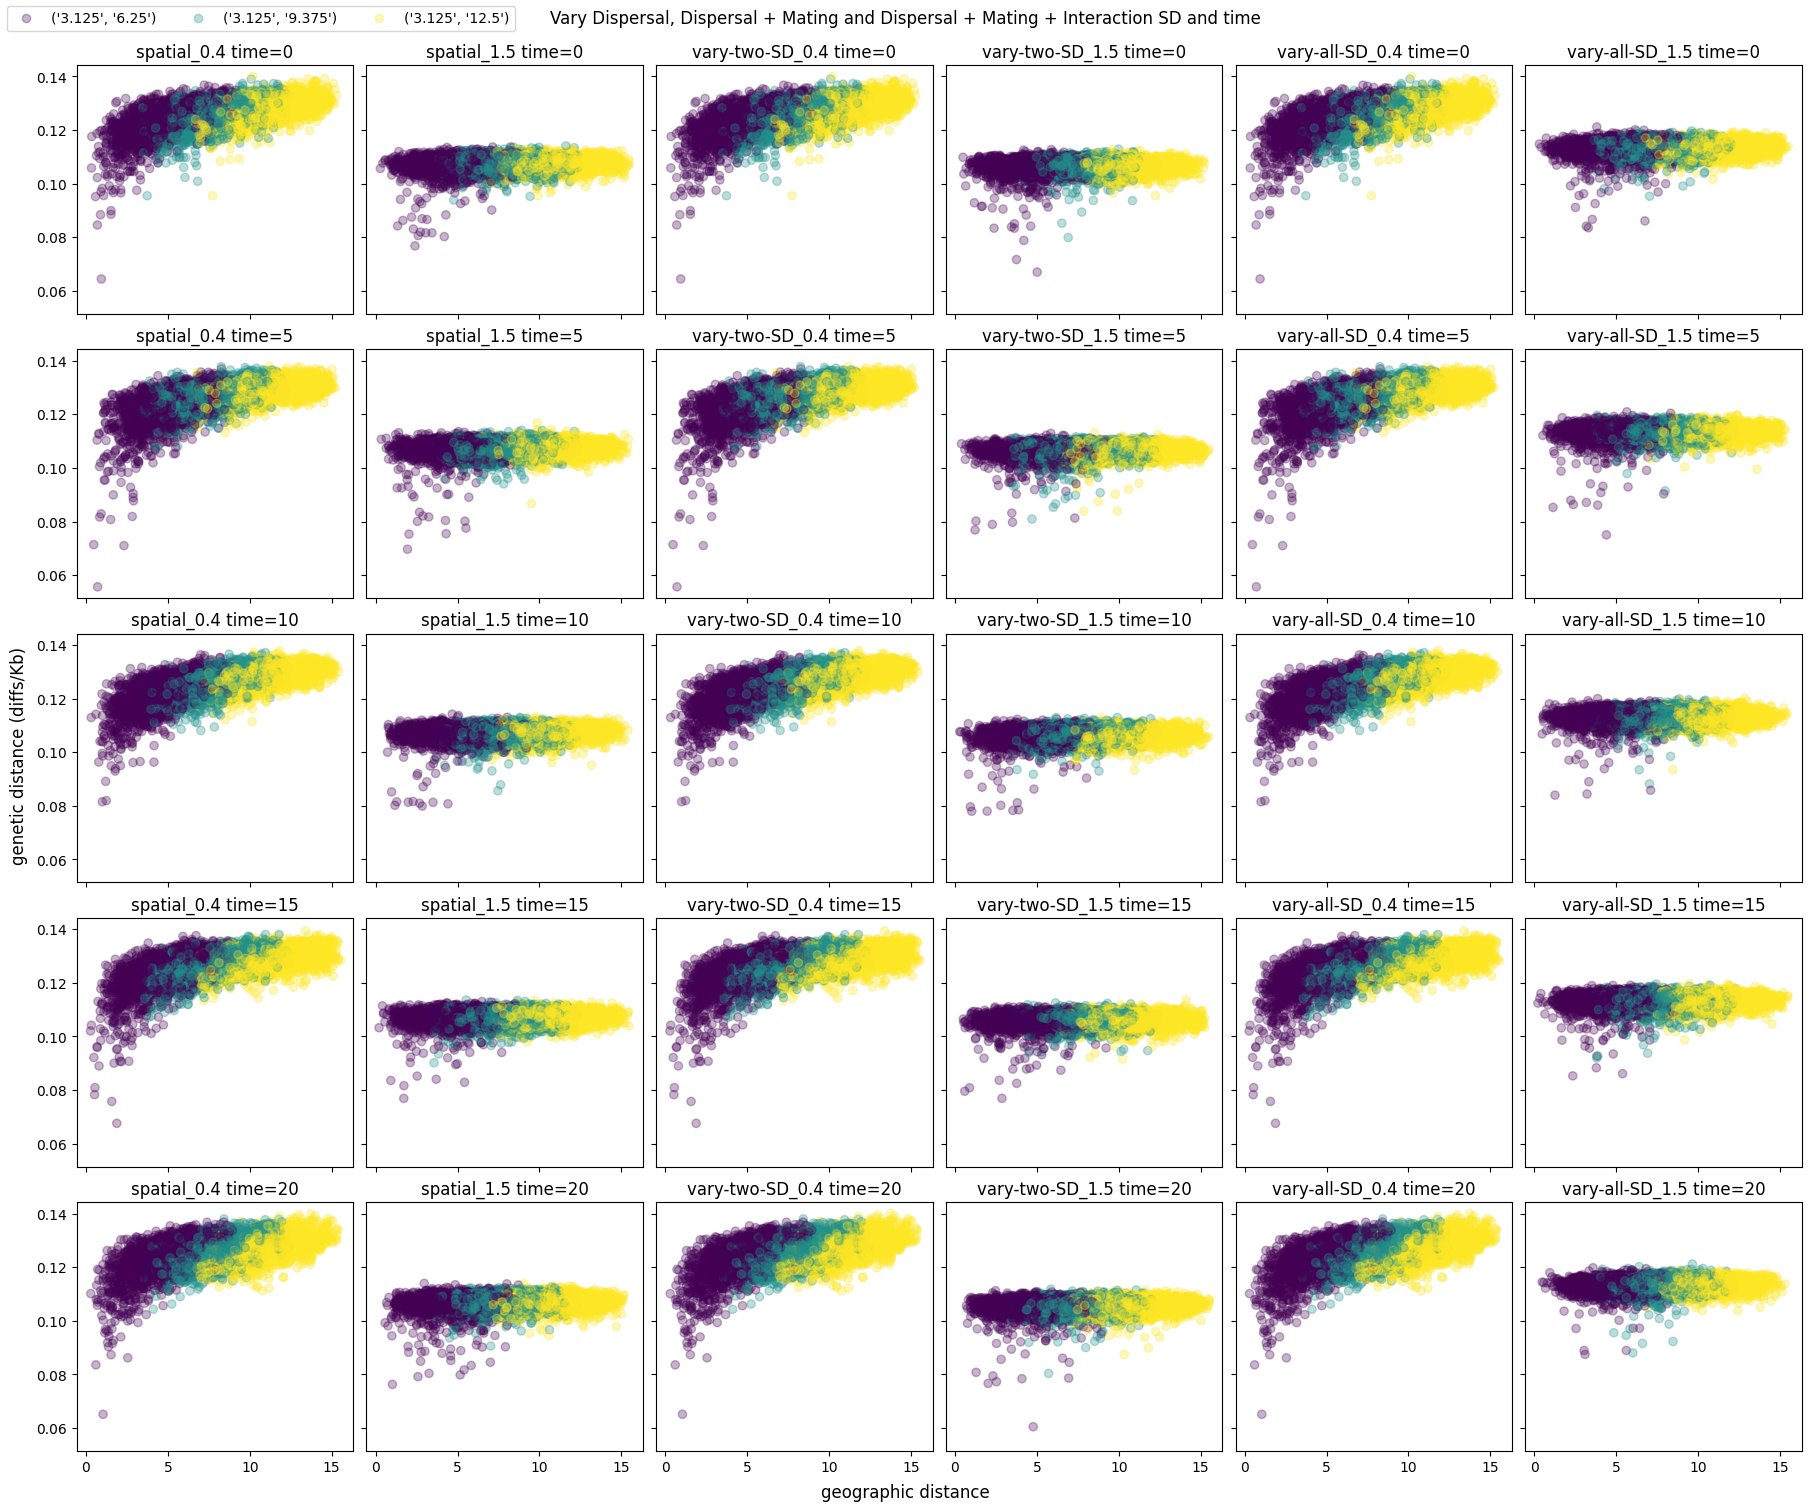

In [165]:
from itertools import product
pairs = [("3.125", "6.25"), ("3.125", "9.375"), ("3.125", "12.5")]
labels = [
    "spatial-runs_spatial_0.4",
    "spatial-runs_spatial_1.5",
    "spatial-runs-vary-two-SD_spatial_0.4",
    "spatial-runs-vary-two-SD_spatial_1.5",
    "spatial-runs-vary-all-SD_spatial_0.4",
    "spatial-runs-vary-all-SD_spatial_1.5",
]
time_points = [0, 5, 10, 15, 20]
title_func = (
    lambda s, i: s.replace("spatial-runs_", "")
    .replace("spatial-runs-", "")
    .replace("_spatial", "") + f' time={i}'
)
fig, axes = plt.subplots(5, 6, figsize=(3 * 6, 3 * 5), sharex=True, sharey=True, layout='constrained')
for (i, t), (j, l) in product(enumerate(time_points), enumerate(labels)):
    ps = PS[l][i]
    leg_elems = plot_divergence(
        ps.divergence,
        ps.geog_distance,
        ps.pairs,
        ps.ind_groups[ps.pairs],
        pairs,
        ax=axes[i, j]
    )
    axes[i, j].set_title(title_func(l, t))
fig.legend(leg_elems, pairs, loc='outside upper left', ncols=len(pairs))
fig.supxlabel("geographic distance")
fig.supylabel("genetic distance (diffs/Kb)")
fig.suptitle("Vary Dispersal, Dispersal + Mating and Dispersal + Mating + Interaction SD and time")
plt.show()

In [65]:
div = PS['spatial-runs_spatial_0.4'][0].divergence
dist = PS['spatial-runs_spatial_0.4'][0].geog_distance
groups = PS['spatial-runs_spatial_0.4'][0].ind_groups[PS['spatial-runs_spatial_0.4'][0].pairs]

In [72]:
mask = np.zeros_like(div, dtype=bool)
for i, p in enumerate(pairs):
    mask[(groups == p).all(1)] |= True

In [74]:
dist[mask]

array([ 2.06639676,  5.35714544,  3.85641339, ..., 13.78013788,
        6.69162854, 10.19845816])

In [75]:
import scipy.stats

In [77]:
bs = scipy.stats.binned_statistic(dist, div)

In [88]:
np.zeros((len(pairs), len(div)), dtype=bool)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [125]:
TSSD = {t.label: t for t in TSS}

In [104]:
# mask = np.zeros_like(div, dtype=bool)
binned = np.zeros((len(PS['spatial-runs_spatial_0.4']), len(pairs), 10))
edges = np.zeros((len(PS['spatial-runs_spatial_0.4']), len(pairs), 10))
for i, ps in enumerate(PS['spatial-runs_spatial_0.4']):
    for j, p in enumerate(pairs):
        mask = np.zeros(len(ps.divergence), dtype=bool)
        mask[(ps.ind_groups[ps.pairs] == p).all(1)] |= True
        bs = scipy.stats.binned_statistic(ps.geog_distance[mask], ps.divergence[mask])
        edges[i, j] = bs.bin_edges[1:]
        binned[i, j] = bs.statistic

In [117]:
from matplotlib.colors import Normalize

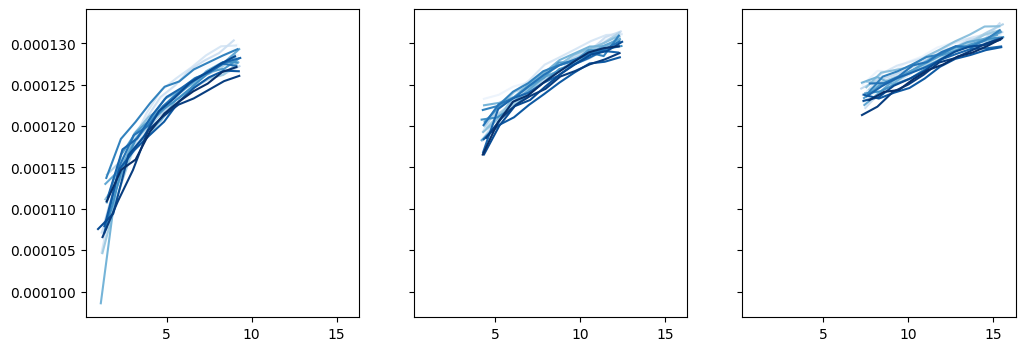

In [142]:
norm = Normalize(0, TSSD['spatial-runs_spatial_0.4'].sampling_times.max())
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for j, l in enumerate(pairs):
    for i in range(binned.shape[0]):
        axes[j].plot(edges[i, j, :], binned[i, j, :], color=plt.cm.Blues(norm(TSSD['spatial-runs_spatial_0.4'].sampling_times[i])))
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=ax)
cbar.set_label('sampling_time')

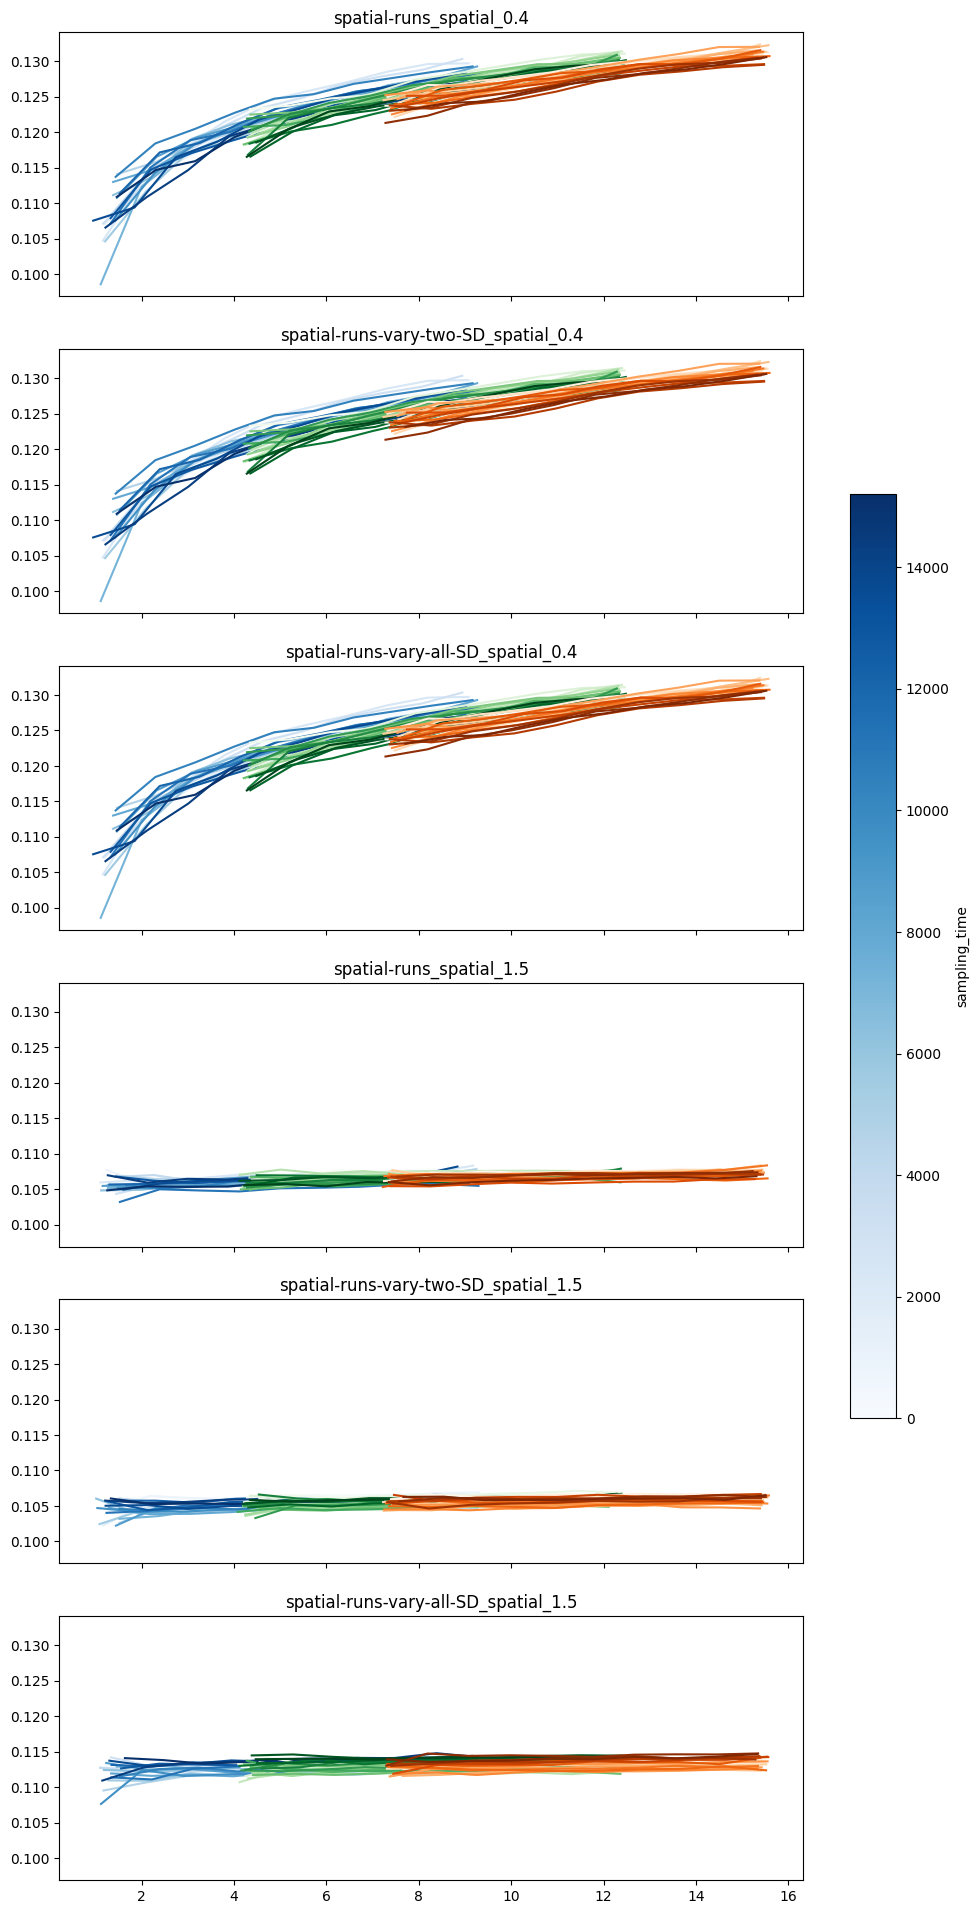

In [184]:
fig, axes = plt.subplots(nrows=len(TSSD), figsize=(12, 4 * len(TSSD)), sharex=True, sharey=True)
for k, l in enumerate(TSSD):
    binned = np.zeros((len(PS[l]), len(pairs), 10))
    edges = np.zeros((len(PS[l]), len(pairs), 10))
    for i, ps in enumerate(PS[l]):
        for j, p in enumerate(pairs):
            mask = np.zeros(len(ps.divergence), dtype=bool)
            mask[(ps.ind_groups[ps.pairs] == p).all(1)] |= True
            bs = scipy.stats.binned_statistic(ps.geog_distance[mask], ps.divergence[mask])
            edges[i, j] = bs.bin_edges[1:]
            binned[i, j] = bs.statistic
    norm = Normalize(0, TSSD[l].sampling_times.max())
    cmaps = [plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges]
    for j in range(len(pairs)):
        for i in range(binned.shape[0]):
            axes[k].plot(edges[i, j, :], binned[i, j, :] * 1e3, color=cmaps[j](norm(TSSD[l].sampling_times[i])))
    axes[k].set_title(l)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmaps[0]), ax=axes[:], location='right', shrink=.5)
cbar.set_label('sampling_time')

In [227]:
axes[0,0

<Axes: title={'center': "('3.125', '6.25') spatial-runs_spatial_0.4"}>

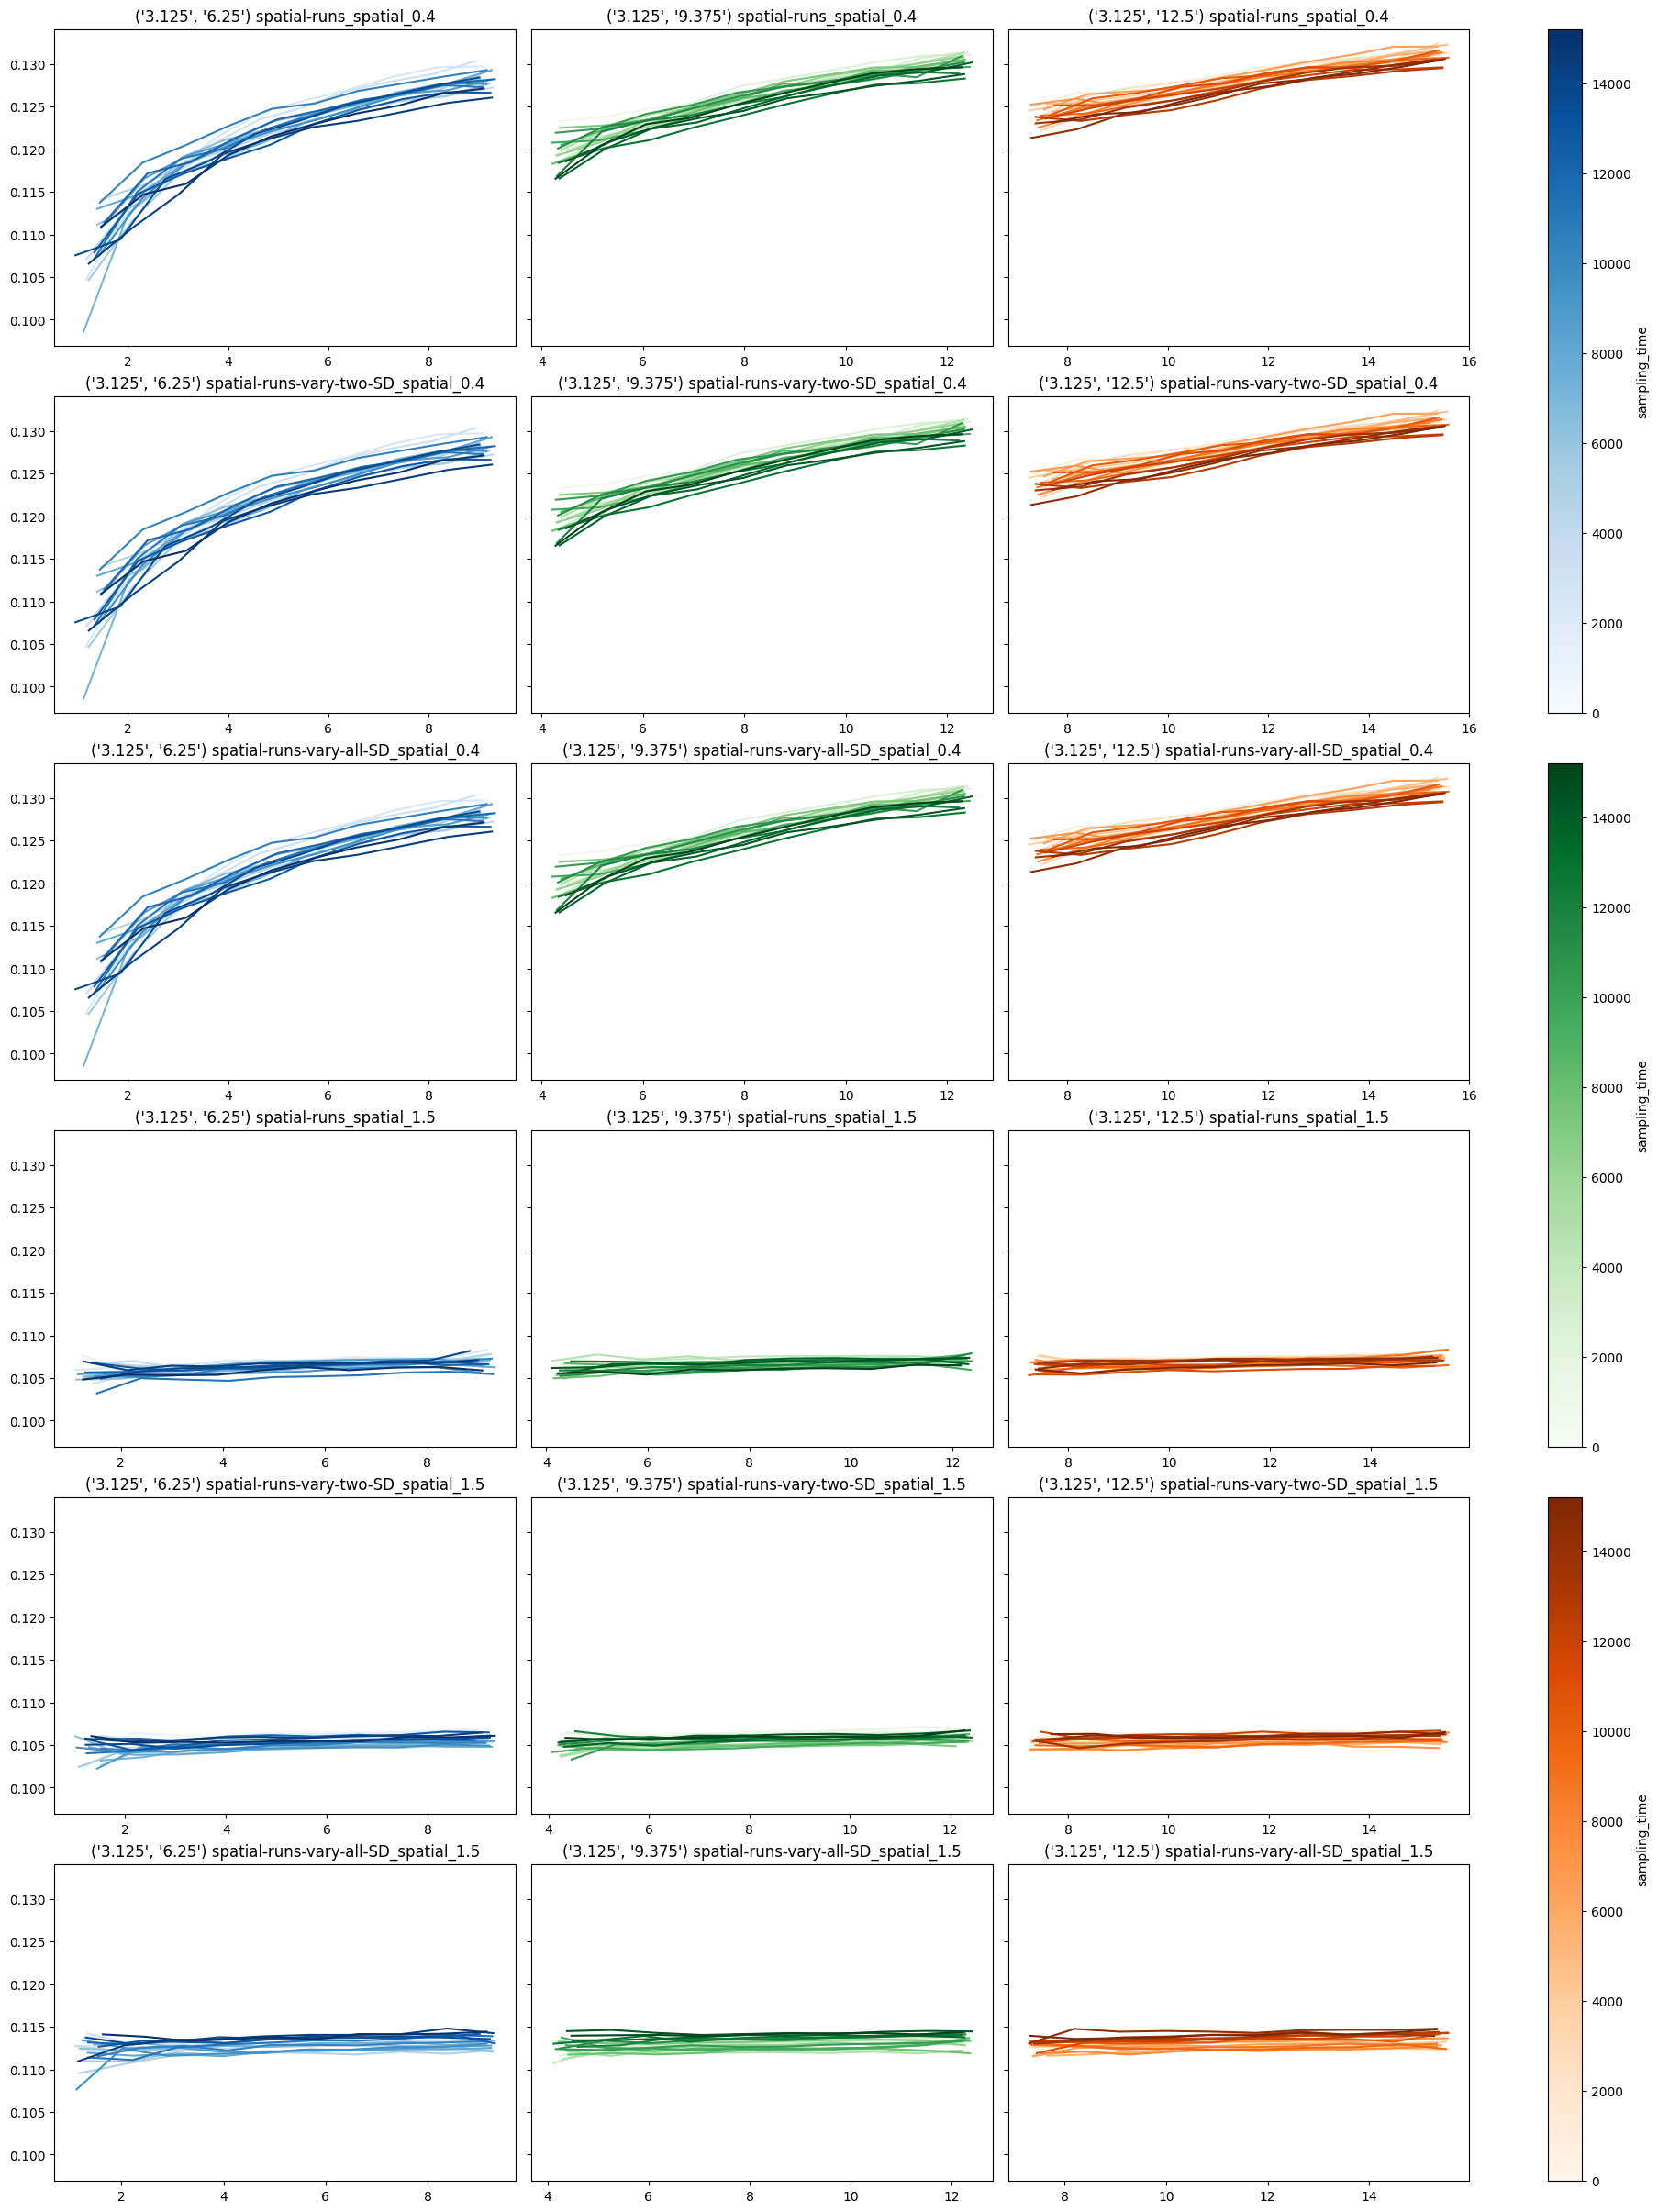

In [230]:
fig, axes = plt.subplots(nrows=len(TSSD), ncols=len(pairs), figsize=(6 * len(pairs), 4 * len(TSSD)), layout='compressed', sharey=True)
for k, l in enumerate(TSSD):
    binned = np.zeros((len(PS[l]), len(pairs), 10))
    edges = np.zeros((len(PS[l]), len(pairs), 10))
    for i, ps in enumerate(PS[l]):
        for j, p in enumerate(pairs):
            mask = np.zeros(len(ps.divergence), dtype=bool)
            mask[(ps.ind_groups[ps.pairs] == p).all(1)] |= True
            bs = scipy.stats.binned_statistic(ps.geog_distance[mask], ps.divergence[mask])
            edges[i, j] = bs.bin_edges[1:]
            binned[i, j] = bs.statistic
    norm = Normalize(0, TSSD[l].sampling_times.max())
    cmaps = [plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges]
    for j in range(len(pairs)):
        for i in range(binned.shape[0]):
            axes[k, j].plot(edges[i, j, :], binned[i, j, :] * 1e3, color=cmaps[j](norm(TSSD[l].sampling_times[i])))
            axes[k, j].set_title(f"{str(pairs[j])} {l}")
    # if l.endswith('1.5'):
    #     axes[k, j].set_ylim(.1, .115)
for i, j in zip(range(0, len(TSS), 2), range(2, len(TSS) + 2, 2)):
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmaps[i // 2]), ax=axes[i:j, :], location='right')
    cbar.set_label('sampling_time')

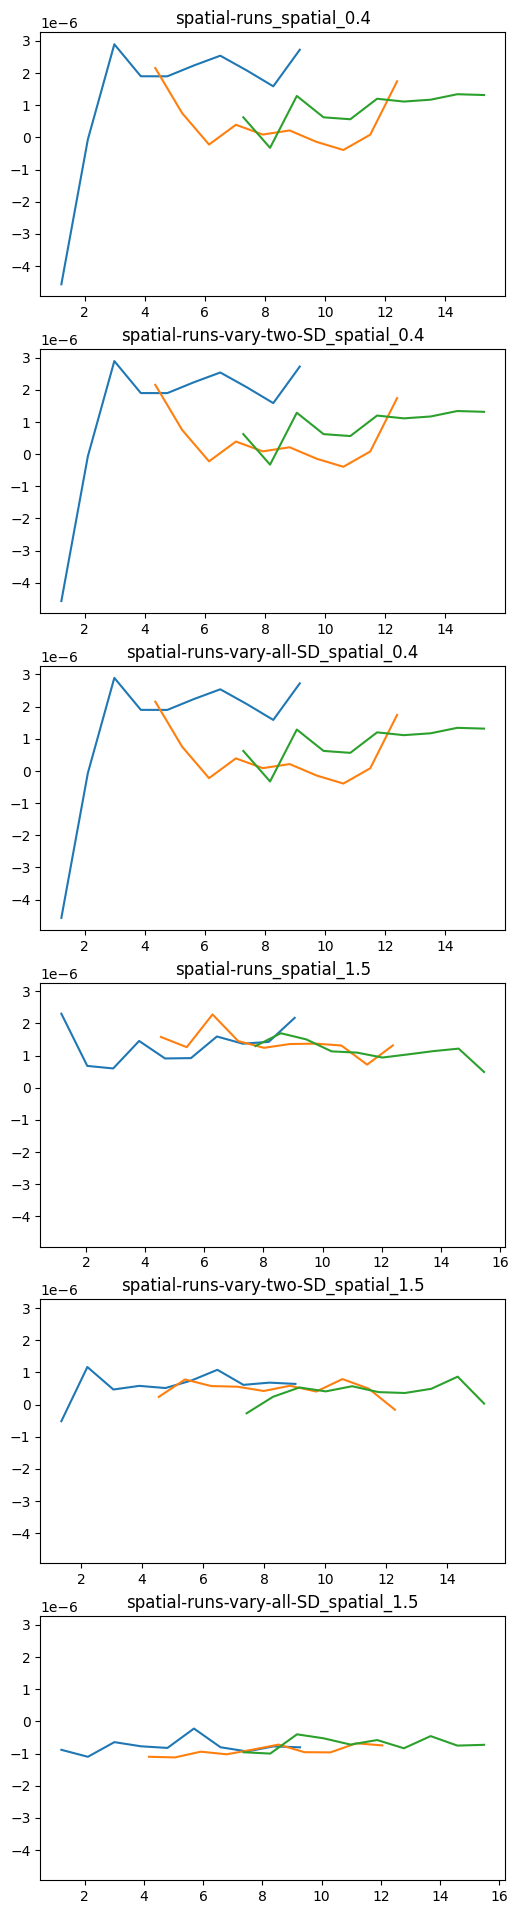

In [223]:
fig, axes = plt.subplots(nrows=len(TSSD), figsize=(6, 4 * len(TSSD)), sharey=True)
for k, l in enumerate(TSSD):
    binned = np.zeros((len(PS[l]), len(pairs), 10))
    edges = np.zeros((len(PS[l]), len(pairs), 10))
    for i, ps in enumerate(PS[l]):
        for j, p in enumerate(pairs):
            mask = np.zeros(len(ps.divergence), dtype=bool)
            mask[(ps.ind_groups[ps.pairs] == p).all(1)] |= True
            bs = scipy.stats.binned_statistic(ps.geog_distance[mask], ps.divergence[mask])
            edges[i, j] = bs.bin_edges[1:]
            binned[i, j] = bs.statistic
    axes[k].plot(edges[0].T, (binned[0] - binned[-1]).T)
    axes[k].set_title(l)